In [1]:
# importing packages
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import json
from tqdm import tqdm
from scipy import stats
import seaborn as sns
import networkx as nx
import pickle
import itertools
from dotmotif import Motif, GrandIsoExecutor
from scipy.stats import kruskal, f_oneway, levene, ranksums, ttest_ind, wilcoxon
from statsmodels.stats.multitest import multipletests

plt.rcParams.update({'font.size': 20})
plt.rcParams["figure.figsize"] = (10,10)
sns.set_theme(style="whitegrid")
random.seed(747)

# Import Stefan's Library for Data Management of V1DD
from lsmm_data import LSMMData
import os
os.chdir('C:/Users/trevo/OneDrive/Allen/important_folders/')

In [2]:
log_summed_psd_by_connection = np.load('C:/Users/trevo/OneDrive/Allen/important_folders/analysis/assembly and centrality/hebbs_hypotheses/data_files/log10_connection_weigts_pyramidal_rect.npy')

In [3]:
def shared(pre, post, A):
    try:
        return not A[pre].isdisjoint(A[post])
    except KeyError:
        return False

def disjoint(pre, post, A):
    try:
        return A[pre].isdisjoint(A[post])
    except KeyError:
        return False

def shared_no_a(pre, post, A):
    return (pre in no_A) and (post in no_A) # type: ignore
    
def no_a_a(pre, post, A):
    return (pre in no_A) and (post not in no_A) # type: ignore

def a_no_a(pre, post, A):
    return (pre not in no_A) and (post in no_A) # type: ignore

comparison_functions = [shared, disjoint, shared_no_a, no_a_a, a_no_a]
groups = ['shared', 'disjoint']

In [4]:
with open('C:/Users/trevo/OneDrive/Allen/important_folders/analysis/assembly and centrality/hebbs_hypotheses/pyr_cells_rectangular_connectome.json') as f:
    lsmm_json_input = json.load(f)
v1dd_data = LSMMData.LSMMData(lsmm_json_input)

data_a = v1dd_data.data
params_a = v1dd_data.params
dirs_a = v1dd_data.dirs
mappings_a = v1dd_data.mappings

Filtering to pyramidal cells only
459


c:\Users\trevo\anaconda3\envs\analysis\Lib\site-packages\lsmm_data\LSMMData.py:391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['structural']['post_cell']['connectome_index'] = data['structural']['post_cell'].index
c:\Users\trevo\anaconda3\envs\analysis\Lib\site-packages\lsmm_data\LSMMData.py:417: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['structural']['post_cell']['pt_position'] = [[data['structural']['post_cell'].iloc[i]['pt_position_x'],data['structural']['post_cell'].iloc[i]['pt_position

Generating Connectome...


100%|██████████| 44293/44293 [02:07<00:00, 346.85it/s]


Generating Connectome...


100%|██████████| 44293/44293 [02:22<00:00, 310.18it/s]


In [5]:
### Pull necessary data from V1DD using LSMMData Manager
cell_table = data_a['structural']['pre_cell'].copy()
cell_table['connectome_index'] = cell_table.index
post_cell_table = data_a['structural']['post_cell'].copy()
post_cell_table['connectome_index'] = post_cell_table.index
synapse_table = data_a['structural']['synapse']

# Establish seperate sets for the pre and post synaptic partnes
# This is necessary as the set of connectome index of pre-synaptic cells do not 
# match the post-synaptic cells due to allowing unproofread post-synaptic targets.
individual_assembly_indexes = [mappings_a['connectome_indexes_by_assembly'][f'A {i}'] for i in range(1,16)]
individual_post_assembly_indexes = [mappings_a['post_connectome_indexes_by_assembly'][f'A {i}'] for i in range(1,16)]

coregistered_post_cell_indexes = mappings_a['assemblies_by_post_connectome_index'].keys()
coregistered_cell_indexes = mappings_a['assemblies_by_connectome_index'].keys()

no_a_cell_indexes = mappings_a['connectome_indexes_by_assembly']['No A']
no_a_post_cell_indexes = mappings_a['post_connectome_indexes_by_assembly']['No A']

pooled_assembly_indexes = list(set(coregistered_cell_indexes) - set(no_a_cell_indexes))
pooled_assembly_post_indexes = list(set(coregistered_post_cell_indexes) - set(no_a_post_cell_indexes))

# Each cell has a distinct root id, so it is unnecessary to establish different sets
assembly_to_root_ids = mappings_a['pt_root_ids_by_assembly']
assembly_root_ids_set = set(mappings_a['assemblies_by_pt_root_id'].keys())

# Filter synapses_table to only synapses between two assembly cells (including No A)
synapses_df = synapse_table[synapse_table['pre_pt_root_id'].isin(assembly_root_ids_set)]
synapses_df = synapses_df[synapses_df['post_pt_root_id'].isin(assembly_root_ids_set)]

# Filter cell tables to only assembly cells
cell_table = cell_table[cell_table['pt_root_id'].isin(assembly_root_ids_set)]
post_cell_table = post_cell_table[post_cell_table['pt_root_id'].isin(assembly_root_ids_set)]

# Finalized set of Root IDs, which are 
pre_root_ids = set(cell_table['pt_root_id'].values)
post_root_ids = set(post_cell_table['pt_root_id'].values)
all_root_ids = pre_root_ids | post_root_ids

In [6]:
### Prep the sets for Analysis, following our description in the Methods section
# Collect our connectomes of pre and post synaptic sets based on the root_ids of the neurons
w = {}
s = {}
b = {}
for pre in pre_root_ids:
    for post in post_root_ids:
        if pre != post:
            w[(pre, post)] = 0
            s[(pre, post)] = 0
            b[(pre, post)] = 0

for i, row in synapses_df.iterrows():
    pre = row['pre_pt_root_id']
    post = row['post_pt_root_id']
    w[(pre, post)] += row['size']
    s[(pre, post)] += 1
    b[(pre, post)] = 1

# Split out assemblies and no_a
assembly_names = set(assembly_to_root_ids.keys()) - set(['No A'])
A_invert = {assembly: set(assembly_to_root_ids[assembly]) for assembly in assembly_names}
no_A = set(assembly_to_root_ids['No A'])
all_coregistered_root_ids = mappings_a['assemblies_by_pt_root_id'].keys()
assembly_root_ids_excluding_no_A = set(all_coregistered_root_ids) - no_A
A = {pt_root_id: set(mappings_a['assemblies_by_pt_root_id'][pt_root_id]) for pt_root_id in all_root_ids if 'No A' not in mappings_a['assemblies_by_pt_root_id'][pt_root_id]}

In [7]:
W_nonzero_pairwise = {}
B_pairwise = {}
for connection_type in comparison_functions:
    W_nonzero_pairwise[connection_type.__name__] = {}
    B_pairwise[connection_type.__name__] = {}
    for (j, i) in w.keys():
        if connection_type(j, i, A):
            B_pairwise[connection_type.__name__][(j, i)] = 1 if w[(j, i)] > 0 else 0
            if w[(j, i)] > 0:
                W_nonzero_pairwise[connection_type.__name__][(j, i)] = w[(j, i)]

In [45]:
connection_data = []

# Iterate through connection types and their connections
for connection_type, connections in W_nonzero_pairwise.items():
    for (pre, post), size in connections.items():
        connection_data.append({
            "pre": pre,
            "post": post,
            "size": size,
            "connection_type": connection_type
        })

# Convert to DataFrame
connections_df = pd.DataFrame(connection_data)

connections_df['size'] = connections_df['size']
connections_df['log_size'] = np.log10(connections_df['size'])

tail_minimum = 3.46002433

connections_df_tail = connections_df[connections_df['log_size'] >= tail_minimum]

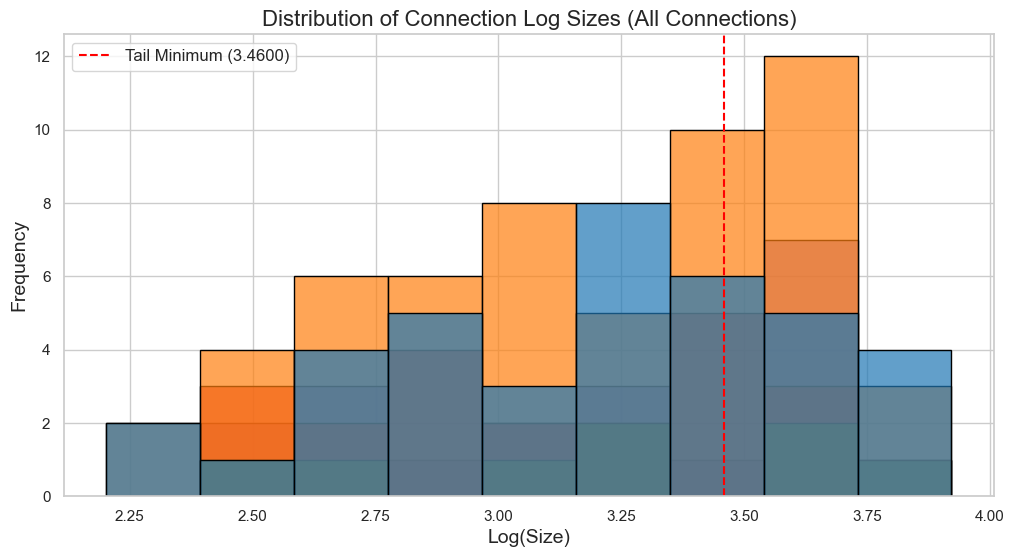

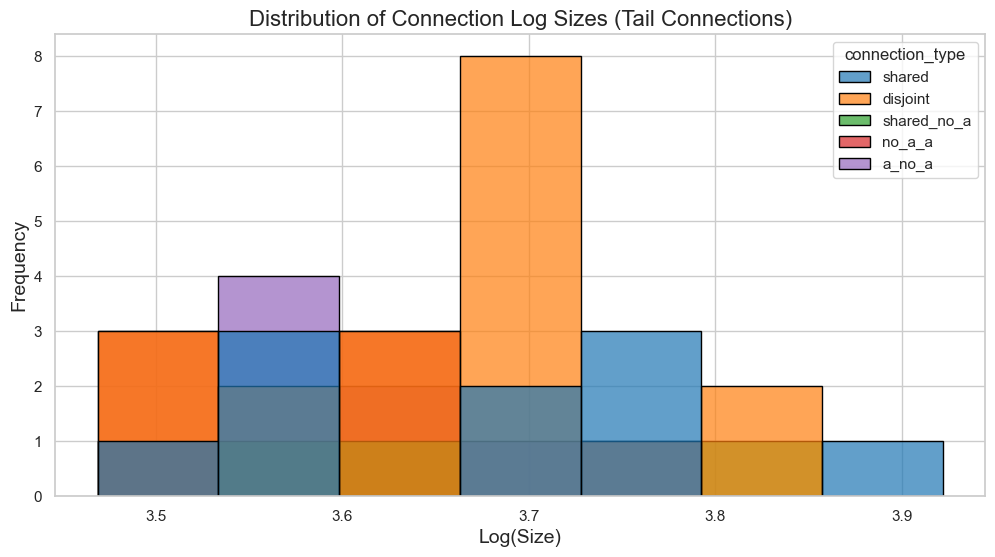

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(12, 6))
sns.histplot(data=connections_df, x='log_size', hue='connection_type', bins='auto', 
             kde=False, palette='tab10', alpha=0.7, edgecolor='black')


plt.axvline(tail_minimum, color='red', linestyle='dashed', label=f"Tail Minimum ({tail_minimum:.4f})")

# Adding labels and title
plt.title("Distribution of Connection Log Sizes (All Connections)", fontsize=16)
plt.xlabel("Log(Size)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend(fontsize=12)


plt.show()


plt.figure(figsize=(12, 6))
sns.histplot(data=connections_df_tail, x='log_size', hue='connection_type', bins='auto', 
             kde=False, palette='tab10', alpha=0.7, edgecolor='black')


plt.title("Distribution of Connection Log Sizes (Tail Connections)", fontsize=16)
plt.xlabel("Log(Size)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)


plt.show()

In [47]:
from scipy.stats import chisquare, skew, kurtosis

shared_count = len(connections_df[connections_df['connection_type'] == 'shared'])
disjoint_count = len(connections_df[connections_df['connection_type'] == 'disjoint'])
total_count = shared_count + disjoint_count

prop_shared = shared_count / total_count
prop_disjoint = disjoint_count / total_count

tail_shared_count = len(connections_df_tail[connections_df_tail['connection_type'] == 'shared'])
tail_disjoint_count = len(connections_df_tail[connections_df_tail['connection_type'] == 'disjoint'])

total_tail_count = tail_shared_count + tail_disjoint_count
expected_shared = total_tail_count * prop_shared
expected_disjoint = total_tail_count * prop_disjoint

observed = [tail_shared_count, tail_disjoint_count]
expected = [expected_shared, expected_disjoint]
chi2_stat, p_value = chisquare(f_obs=observed, f_exp=expected)

print("Chi-squared test results:")
print(f"Observed counts: Shared = {observed[0]}, Disjoint = {observed[1]}")
print(f"Expected counts: Shared = {expected[0]:.2f}, Disjoint = {expected[1]:.2f}")
print(f"Chi-squared statistic: {chi2_stat:.4f}")
print(f"P-value: {p_value:.4e}")

Chi-squared test results:
Observed counts: Shared = 10, Disjoint = 19
Expected counts: Shared = 11.72, Disjoint = 17.28
Chi-squared statistic: 0.4253
P-value: 5.1432e-01


In [48]:
def bootstrap_one_sided_ci(df, group1, group2, stat_func, n_resamples=10000, alpha=0.05):
    """Bootstrap one-sided confidence interval for a statistic."""
    group1_values = df[df['connection_type'] == group1]['log_size'].values
    group2_values = df[df['connection_type'] == group2]['log_size'].values
    observed_diff = stat_func(group1_values) - stat_func(group2_values)
    
    # Bootstrap resampling
    boot_diffs = []
    for _ in range(n_resamples):
        boot_group1 = np.random.choice(group1_values, size=len(group1_values), replace=True)
        boot_group2 = np.random.choice(group2_values, size=len(group2_values), replace=True)
        boot_diff = stat_func(boot_group1) - stat_func(boot_group2)
        boot_diffs.append(boot_diff)
    
    ci_lower = np.percentile(boot_diffs, alpha * 100)  # e.g., 5th percentile for 95% one-sided CI
    
    return observed_diff, ci_lower

skew_diff, skew_ci_lower = bootstrap_one_sided_ci(
    connections_df_tail, 'shared', 'disjoint', skew
)
print(f"Skewness difference (observed): {skew_diff:.4f}")
print(f"One-sided 95% lower confidence bound for skewness difference: {skew_ci_lower:.4f}")

# Compute one-sided CI for kurtosis
kurt_diff, kurt_ci_lower = bootstrap_one_sided_ci(
    connections_df_tail, 'shared', 'disjoint', kurtosis
)
print(f"Kurtosis difference (observed): {kurt_diff:.4f}")
print(f"One-sided 95% lower confidence bound for kurtosis difference: {kurt_ci_lower:.4f}")

Skewness difference (observed): 0.1080
One-sided 95% lower confidence bound for skewness difference: -1.0542
Kurtosis difference (observed): -0.4338
One-sided 95% lower confidence bound for kurtosis difference: -2.1510


In [49]:
connection_types = connections_df['connection_type'].unique()
proportions = {
    connection_type: len(connections_df[connections_df['connection_type'] == connection_type]) / len(connections_df)
    for connection_type in connection_types
}

observed_counts = {
    connection_type: len(connections_df_tail[connections_df_tail['connection_type'] == connection_type])
    for connection_type in connection_types
}
total_tail = sum(observed_counts.values())

expected_counts = {
    connection_type: total_tail * proportions[connection_type]
    for connection_type in connection_types
}

# Step 4: Perform chi-squared test
observed = list(observed_counts.values())
expected = list(expected_counts.values())
chi2_stat, p_value = chisquare(f_obs=observed, f_exp=expected)

print("Chi-squared test results:")
print(f"Observed counts: {observed_counts}")
print(f"Expected counts: {expected_counts}")
print(f"Chi-squared statistic: {chi2_stat:.4f}")
print(f"P-value: {p_value:.4e}")

Chi-squared test results:
Observed counts: {'shared': 10, 'disjoint': 19, 'shared_no_a': 3, 'no_a_a': 6, 'a_no_a': 9}
Expected counts: {'shared': 12.48951048951049, 'disjoint': 18.405594405594407, 'shared_no_a': 2.629370629370629, 'no_a_a': 6.902097902097902, 'a_no_a': 6.573426573426574}
Chi-squared statistic: 1.5813
P-value: 8.1214e-01
